# **Project Title**: Dating App Review Analysis - Topic Modeling & Sentiment Insights

**Project Objectives**:

To extract and understand the user experiences from online reviews of popular dating apps (Tinder, Bumble, Hinge) by implementing Latent Dirichlet Allocation and sentimental analysis. Aiming to identify the common pain points, satisfaction areas, and improvement opportunities.

## 1. Data Overview

We use scraped Google Play reviews from dating apps such as Tinder, Bumble, and Hinge from Kaggle. The dataset contains raw user text, review timestamps, star ratings, and platform metadata.

In [1]:
# Import the libraries
import pandas as pd
import numpy as np
import re
import string
import spacy

# Visualization libraries
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

# NLTK libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Gensim libraries
from gensim import corpora
from gensim.models import LdaModel, LdaMulticore, CoherenceModel
import pyLDAvis.gensim

from datetime import datetime, timedelta

In [2]:
# Combining the datasets of three different dating platforms
apps = ['tinder', 'bumble', 'hinge']

In [3]:
# Add all files to a list
paths = ['updated_data/{}.csv'.format(make) for make in apps ]
type(paths) 

list

In [4]:
# Concatenate 3 cvs files
df_list = [pd.read_csv(path).assign(platform=app) for path, app in zip(paths, apps)]
combined_df = pd.concat(df_list, ignore_index=True)
combined_df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion,platform
0,1d1370cf-108a-489b-bfba-561b1608c4ba,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I got banned and I didn't even get to use the app,1,0,16.5.1,2025-04-11 00:22:03,NaN,NaN,16.5.1,tinder
1,4eb0041a-6948-4d19-8045-468887208330,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,It's a nice place to make new friends!,5,0,16.5.1,2025-04-11 00:10:07,NaN,NaN,16.5.1,tinder
2,25e0a6a3-4afb-4d6e-9ca0-2f47f5213e23,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,You get banned for no reason 👎🏻👎🏻,1,0,NaN,2025-04-11 00:04:07,NaN,NaN,NaN,tinder
3,459cec9a-5752-45f8-8002-1fb8c203a3b7,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,I don't have money to pay,4,0,16.5.1,2025-04-10 23:55:09,NaN,NaN,16.5.1,tinder
4,8469a367-50d7-4863-9850-6c762c737ccf,A Google user,https://play-lh.googleusercontent.com/EGemoI2N...,wonderful experience,5,0,NaN,2025-04-10 23:45:16,NaN,NaN,NaN,tinder


In [5]:
# Make a copy to protect the original dataframe 
df = combined_df.copy()

## 2. Data Pre-processing
We removed unnecessary columns and renamed the remaining ones for clarity. We also checked for null values and duplicates, standardized the date format, converted text to lowercase, and cleaned the data by removing emojis, punctuation, and extra whitespace.

In [6]:
# Drop unneeded data columns
df.drop(['reviewId','userName','userImage', 'replyContent', 'repliedAt', 'thumbsUpCount', 'reviewCreatedVersion', 'appVersion'], axis = 1, inplace = True)

# Check the data info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 890897 entries, 0 to 890896
Data columns (total 4 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   content   889515 non-null  object
 1   score     890897 non-null  int64 
 2   at        890897 non-null  object
 3   platform  890897 non-null  object
dtypes: int64(1), object(3)
memory usage: 27.2+ MB


In [7]:
# Rename the column for clarity
df.rename(columns={'content': 'review', 'score': 'rating', 'at': 'date'}, inplace=True)

In [8]:
# Check for nun values
df.isnull().sum()

review      1382
rating         0
date           0
platform       0
dtype: int64

In [9]:
# Drop all duplicates
df.drop_duplicates(inplace=True)

In [10]:
# Change date format 
# Convert to datetime and filter within 5 years
df['date'] = pd.to_datetime(df['date'])
cutoff = datetime(2025, 4, 13) - timedelta(days=5 * 365)

# Filter and reformat the date
df = df[df['date'] > cutoff]
df['date'] = df['date'].dt.strftime('%Y-%m-%d')
df.head()

,review,rating,date,platform
0,I got banned and I didn't even get to use the app,1,2025-04-11,tinder
1,It's a nice place to make new friends!,5,2025-04-11,tinder
2,You get banned for no reason 👎🏻👎🏻,1,2025-04-11,tinder
3,I don't have money to pay,4,2025-04-10,tinder
4,wonderful experience,5,2025-04-10,tinder


In [11]:
# Conver all data to lower case
df['review'] = df['review'].str.lower()

In [12]:
# Remove Emoji
emoji_pattern = re.compile("[\U00010000-\U0010FFFF]", flags=re.UNICODE)
mask = df['review'].astype(str).str.contains(emoji_pattern, regex=True)
df = df[~mask]

In [13]:
# Remove puntuation
df['review'] = df['review'].astype(str).str.replace(f"[{re.escape(string.punctuation)}]", "", regex=True)
df.head()

,review,rating,date,platform
0,i got banned and i didnt even get to use the app,1,2025-04-11,tinder
1,its a nice place to make new friends,5,2025-04-11,tinder
3,i dont have money to pay,4,2025-04-10,tinder
4,wonderful experience,5,2025-04-10,tinder
5,this app just steals money from you,1,2025-04-10,tinder


In [14]:
# Remove extra white space
df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True).str.strip()
df.head()

,review,rating,date,platform
0,i got banned and i didnt even get to use the app,1,2025-04-11,tinder
1,its a nice place to make new friends,5,2025-04-11,tinder
3,i dont have money to pay,4,2025-04-10,tinder
4,wonderful experience,5,2025-04-10,tinder
5,this app just steals money from you,1,2025-04-10,tinder


## Exploratory Data Analysis (EDA)
For the exploratory data analysis (EDA), we examined the distribution of reviews across platforms and analyzed their average ratings. Furthermore, we explored how the number of reviews and ratings evolved over time to extract meaningful trends in dating app usage. Additionally, we generated a word cloud to obtain an initial overview of common user experiences.

In [15]:
# Review count for each platform
platform_review_count = df.groupby('platform').count()['review'].reset_index()
platform_review_count

,platform,review
0,bumble,103667
1,hinge,45203
2,tinder,240560


In [ ]:
# Percentage for each platform
platform_review_pct = df['platform'].value_counts(normalize = True).round(2) * 100 
platform_review_pct

platform
tinder    62.0
bumble    27.0
hinge     12.0
Name: proportion, dtype: float64

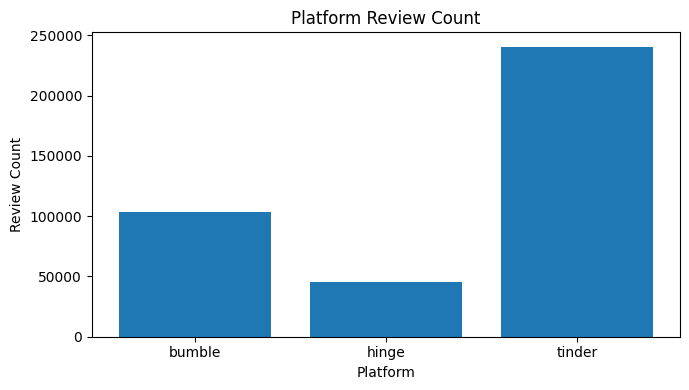

In [ ]:
# Barchart for platforms reviews count
plt.figure(figsize=(7,4))
plt.bar(platform_review_count['platform'], platform_review_count['review'])
plt.title('Platform Review Count')
plt.xlabel('Platform')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

The review count is heavily skewed toward Tinder, indicating that its reviews may significantly influence the overall results and should be interpreted with that bias in mind.

In [18]:
# The review count for each brand by rating
grouped_brand = df.groupby([df.platform, df.rating]).size().reset_index().rename(columns = {0: 'counts'})
grouped_brand

,platform,rating,counts
0,bumble,1,56947
1,bumble,2,8831
2,bumble,3,6914
3,bumble,4,7853
4,bumble,5,23122
5,hinge,1,25051
6,hinge,2,5060
7,hinge,3,3893
8,hinge,4,3575
9,hinge,5,7624


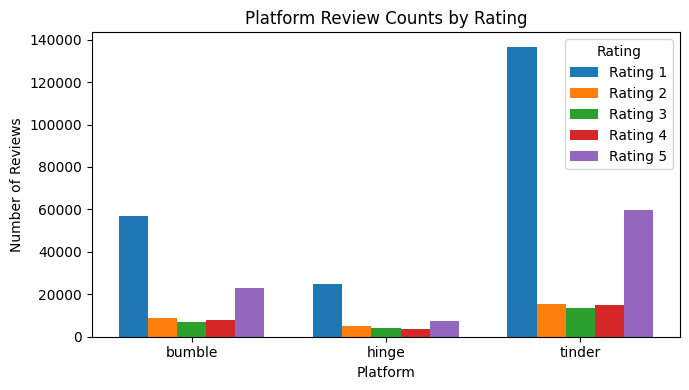

In [ ]:
# Grouped bar chart for each brand by rating
ratings = sorted(grouped_brand['rating'].unique())

pivot_df = grouped_brand.pivot(index='platform', columns='rating', values='counts').fillna(0)

x = np.arange(len(pivot_df))
bar_width = 0.15

# Plot
plt.figure(figsize=(7,4))
for i, rating in enumerate(pivot_df.columns):
    plt.bar(x + i * bar_width, pivot_df[rating], width=bar_width, label=f'Rating {rating}')
plt.xticks(x + bar_width * (len(pivot_df.columns) - 1) / 2, pivot_df.index)
plt.title('Platform Review Counts by Rating')
plt.xlabel('Platform')
plt.ylabel('Number of Reviews')
plt.legend(title='Rating')
plt.tight_layout()
plt.show()

Observation:
All apps are receiving low ratings, with rating 1 appearing most frequently across all platforms.
Interestingly, rating 5 is the second most common, indicating that users tend to have either very negative or very positive experiences.

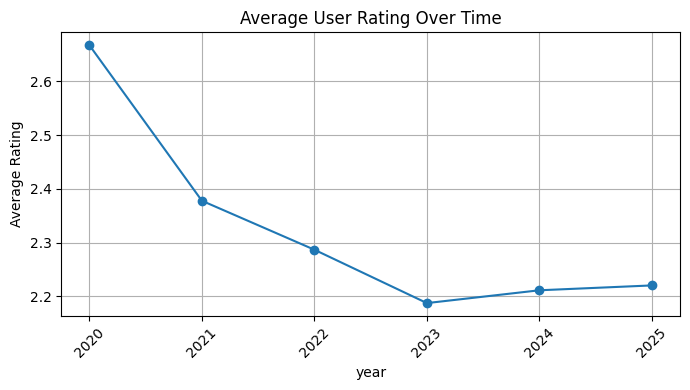

In [20]:
# Average rating over time
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Group by year
df['year'] = df['date'].dt.to_period('Y')
monthly_rating = df.groupby('year')['rating'].mean().reset_index()

# Plot 
plt.figure(figsize=(7,4))
plt.plot(monthly_rating['year'].astype(str), monthly_rating['rating'], marker='o')
plt.xticks(rotation=45)
plt.title('Average User Rating Over Time')
plt.xlabel('year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.tight_layout()
plt.show()


Observation:
The average rating score peaked in 2018 and has continued to decrease rapidly since then, up to 2023. The data does indicate a trend that users are becoming increasingly dissatisfied with their experience over time. 

Regression line: y = -41.52 * x + 7629.76


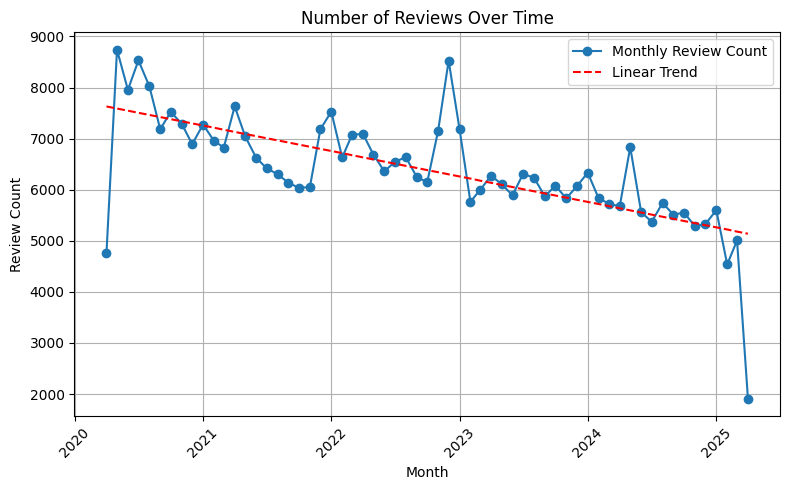

In [ ]:
# Explore review volume over time
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period('M') 
monthly_counts = df['month'].value_counts().sort_index()
x_dates = monthly_counts.index.to_timestamp()

x_vals = np.arange(len(x_dates))
y_vals = monthly_counts.values

# Fit linear regression line
slope, intercept = np.polyfit(x_vals, y_vals, 1)
regression_line = slope * x_vals + intercept
print(f"Regression line: y = {slope:.2f} * x + {intercept:.2f}")

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x_dates, y_vals, marker='o', label='Monthly Review Count')
plt.plot(x_dates, regression_line, color='red', linestyle='--', label='Linear Trend')
plt.title('Number of Reviews Over Time')
plt.xlabel('Month')
plt.ylabel('Review Count')
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

Observation:
We observe that the number of reviews is decreasing over time at a rate of 41.52 reviews per month. This trend, along with the decline in average ratings, indicates growing user dissatisfaction. The shrinking review volume may also suggest a loss of user engagement or even a drop in the active user base.

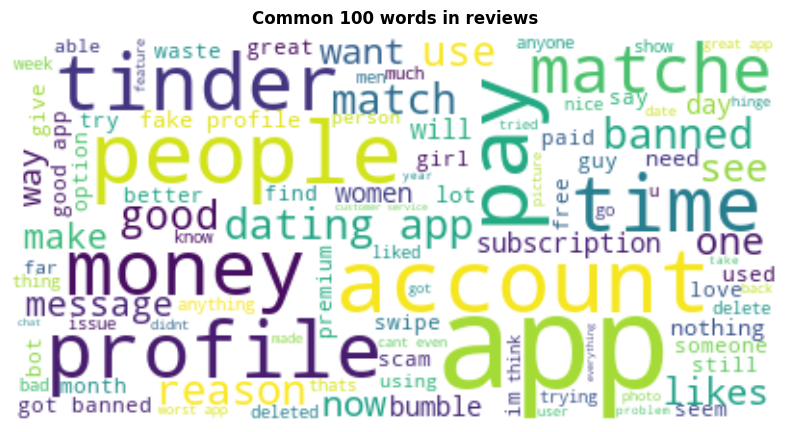

In [ ]:
# Creat a Wordcloud
long_string = ','.join(list(df.review.values))

wordcloud = WordCloud(background_color="white", max_words=100, contour_width=3)
wordcloud.generate(long_string)

plt.figure(figsize= (10,5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title("Common 100 words in reviews", pad = 10, weight = 'bold')
plt.show()

Observation:
The word "profile" appears to be one of the most common terms in the reviews, reflecting various aspects of the user experience. The completeness or setup of a profile may be a crucial factor in user satisfaction, as appearance often comes before meaningful engagement on dating apps.

Other key terms, including "money," "pay," and "time" are also prominent in the word cloud. This suggests that pricing and perceived value are important considerations for users when evaluating their overall experience.


## Latent Dirichlet Allocation (LDA)
We extracted stop words and use Gensim’s LdaMulticore to extract latent topics. Coherence scores guide the selection of topic count.

LDA model explaination: 

Latent Dirichlet Allocation (LDA) is a probabilistic generative model that treats each document as a mixture of underlying topics, with each word assigned to one of those topics. It infers both the distribution of topics across the corpus and the distribution of words within each topic.

Better LDA model is the one with higher coherence score (more coherent and easier to label the topics) and lower perplexity (better at generalizing - the model is assigning higher probability to the actual words).

In [ ]:
# Removed stop words and words shorter than 2 letters; performed tokenization and lemmatization
# Note: Since the data consists of online reviews, the text contains various types of noise, including abbreviations and slang

nlp = spacy.load("en_core_web_sm", disable=["ner", "parser"])
custom_stop_words = {
    'app', 'apps', 'application', 'version', 'update', 'feature', 'option', 'device', 'phone', 'platform', 'account',
    'star', 'stars', 'rating', 'review', 'reviews', 'rate', 'log', 'login', 'sign', 'signing', 'signup', 'download',
    'get', 'got', 'make', 'take', 'use', 'using', 'used', 'see', 'look', 'find', 'set', 'give', 'tell', 'put', 'keep',
    'try', 'tried', 'change', 'help', 'email', 'contact', 'team', 'issue', 'problem', 'day', 'week', 'month', 'year',
    'minute', 'second', 'hour', 'time', 'every', 'always', 'never', 'sometimes', 'still', 'paid', 'paying', 'charge',
    'photo', 'username', 'nice', 'great', 'good', 'bad', 'best', 'worst', 'awesome', 'cool', 'okay', 'literally',
    'honestly', 'definitely', 'mostly', 'sure', 'lot', 'many', 'much', 'alot', 'really', 'just', 'even', 'also',
    'actually', 'someone', 'everyone', 'anyone', 'thing', 'stuff', 'something', 'guy', 'girl', 'man', 'people', 'person',
    'well', 'back', 'yet', 'without', 'around', 'across', 'n/a', 'hai', 'tats', 'gon', 'aap', 'para', 'que', 'breal', 
    'work', 'reason', 'send', 'hinge', 'like', 'want', 'easy', 'play', 'google', 'away', 'date', 'tinder', 'bumble', 'think'
    'experience', 'let', 'number', 'lol', 'new'
}

all_stopwords = nlp.Defaults.stop_words.union(custom_stop_words)

texts = df['review'].astype(str).str.lower().tolist()
docs = nlp.pipe(texts, batch_size=1000, n_process=-1)

df['filtered_tokens'] = [
    [token.lemma_ for token in doc if token.is_alpha and len(token.lemma_) > 2 and token.lemma_ not in all_stopwords]
    for doc in docs
]

filtered_tokens = df['filtered_tokens'].tolist()

c:\Users\xiwen\AppData\Local\Programs\Python\Python312\Lib\site-packages\spacy\util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.8.0) was trained with spaCy v3.8.0 and may not be 100% compatible with the current version (3.7.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [ ]:
# Create Dictionary
id2word_1 = corpora.Dictionary(filtered_tokens)

# Create Corpus: Term Document Frequency
corpus_1 = [id2word_1.doc2bow(review) for review in filtered_tokens]

def quick_coherence(id2word, corpus, texts, topic_range, passes=30, iterations=400):
    """
    Train LDA models over a range of topic numbers and compute their coherence scores.
    """
    coherence_scores = []
    models = []
    for num_topics in topic_range:
        model = LdaMulticore(
            corpus=corpus,
            id2word=id2word,
            num_topics=num_topics,
            random_state=5,
            passes=passes,
            iterations=iterations,
            workers=3,
            chunksize=500,
            alpha='asymmetric',
            eta='auto'
        )
        coherence = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_scores.append(coherence.get_coherence())
        models.append(model)
        print(f"Computed coherence for {num_topics} topics: {coherence_scores[-1]:.4f}")
    return models, coherence_scores


Computed coherence for 3 topics: 0.5420
Computed coherence for 4 topics: 0.6173
Computed coherence for 5 topics: 0.5965
Computed coherence for 6 topics: 0.6098
Computed coherence for 7 topics: 0.5886


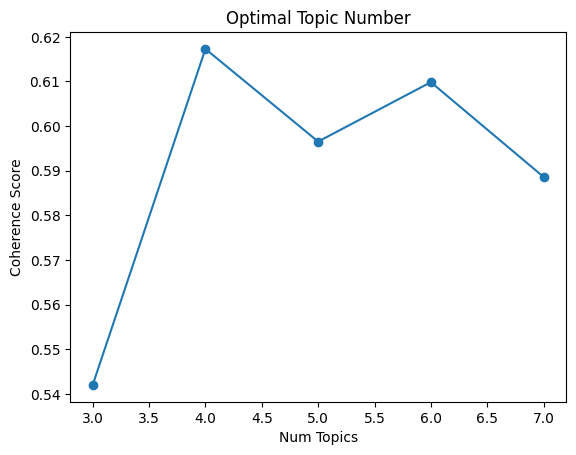

In [27]:
# Execute and find the highest coherence score
topic_range = range(3,8) 
models, coherence_scores = quick_coherence(
    id2word_1, corpus_1, filtered_tokens, topic_range
)

plt.plot(topic_range, coherence_scores, marker='o')
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.title('Optimal Topic Number')
plt.show()

In [28]:
# Print the optimal model and its topics and words
best_idx = coherence_scores.index(max(coherence_scores))
optimal_model = models[best_idx]
best_topic_num = topic_range[best_idx]

print(f"\nBest Number of Topics: {best_topic_num}")
print(f"Highest Coherence Score: {coherence_scores[best_idx]:.4f}\n")
print('\nPerplexity: ', optimal_model.log_perplexity(corpus_1))  
print("Topics from Best Model:\n")
for idx, topic in optimal_model.print_topics(num_topics=-1, num_words=10):
    print(f"Topic {idx+1}:\n{topic}\n")


Best Number of Topics: 4
Highest Coherence Score: 0.6173


Perplexity:  -7.563518246932829
Topics from Best Model:

Topic 1:
0.026*"ban" + 0.021*"delete" + 0.015*"profile" + 0.013*"subscription" + 0.011*"know" + 0.011*"service" + 0.009*"experience" + 0.009*"message" + 0.009*"support" + 0.008*"love"

Topic 2:
0.047*"profile" + 0.035*"woman" + 0.029*"waste" + 0.028*"fake" + 0.027*"meet" + 0.024*"money" + 0.020*"far" + 0.015*"filter" + 0.013*"real" + 0.013*"site"

Topic 3:
0.099*"match" + 0.088*"pay" + 0.035*"message" + 0.030*"swipe" + 0.025*"free" + 0.022*"premium" + 0.014*"money" + 0.014*"notification" + 0.014*"right" + 0.011*"buy"

Topic 4:
0.048*"open" + 0.042*"load" + 0.034*"bug" + 0.023*"screen" + 0.019*"reinstall" + 0.018*"glitch" + 0.018*"interesting" + 0.017*"error" + 0.017*"fix" + 0.012*"fail"



In [29]:
#Visualize the topic
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(optimal_model, corpus=corpus_1, dictionary=id2word_1,sort_topics=False)
LDAvis_prepared


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.132267  0.044056       1        1  45.031030
1      0.128174 -0.293853       2        1  23.653525
2      0.146432  0.241229       3        1  23.518653
3     -0.406873  0.008569       4        1   7.796793, topic_info=             Term          Freq         Total Category  logprob  loglift
50          match  53611.000000  53611.000000  Default  30.0000  30.0000
4             pay  47340.000000  47340.000000  Default  29.0000  29.0000
69        profile  41277.000000  41277.000000  Default  28.0000  28.0000
110         woman  18770.000000  18770.000000  Default  27.0000  27.0000
40          swipe  16252.000000  16252.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
22085         bee    623.468336    624.307182   Topic4  -5.6591   2.5501
279           fix   2963.246614   7562.274388   Topic4  -4.1003   1.6146
1636   uninstalle   1258.555001   2461.843890   Topic4  -4.9567   1.8805
355    connection   1044.615996   3870.909958   Topic4  -5.1430   1.2416
1234        stick    767.672332   1881.261323   Topic4  -5.4510   1.6551

[194 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
116       1  0.745621        able
116       3  0.254319        able
147       1  0.999719  absolutely
467       2  0.309479   algorithm
467       3  0.690406   algorithm
...     ...       ...         ...
1392      4  0.999623        wifi
110       2  0.999956       woman
803       2  0.240435       worth
803       3  0.759422       worth
135       1  0.999807       wrong

[199 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4])

**Observation**: 

The LDA model presents clear themes, as most topics are well separated. Topics 1 and 3 slightly overlap at the edges, indicating that the topics are similar and may be related. From the visualization, Topic 1 has the highest prevalence, showing the most marginal topic distribution. In addition, Topic 4 appears isolated on the two-dimensional map, suggesting it may be more distinct than the other topics (likely focusing specifically on technical UI bugs rather than general user experience).

Interpreting the most relevant terms for topics:
First, set the λ (lambda) value to 0.6 to examine the most frequent terms in the topic. Then, set λ to 0 to identify the most unique terms. This approach balances frequency and uniqueness when interpreting topics.

Topic 1

λ = 0.6: "ban", "delete", "profile", "subscription", "know", "service"

λ = 0: "ban", "delete", "subscription", "know", "service", "experience"

Topic 2

λ = 0.6: "profile", "woman", "waste", "fake", "meet", "money"

λ = 0: "woman", "waste", "fake", "meet", "far", "filter"

Topic 3

λ = 0.6: "match", "pay", "message", "swipe", "free", "premium"

λ = 0: "match", "pay", "swipe", "premium", "right", "buy"

Topic 4

λ = 0.6: "open", "load", "bug", "screen", "reinstall", "glitch", "interesting"

λ = 0: "open", "load", "bug", "screen", "reinstall", "glitch"

Changing the λ value did not cause significant differences in the most relevant words for each topic, suggesting that the most frequent words are also the most unique to their respective topics. This indicates that the topics are relatively distinct in their top words. However, it may also suggest low vocabulary diversity after preprocessing, which could be due to the nature of online reviews—these often contain specific complaint clusters. As a result, changing λ does not reveal many additional anchor terms.

## Sentimental Analysis 
We apply sentiment scoring to each review and compute the average sentiment per topic based on its dominant topic assignment. Through sentiment analysis, we can examine the emotions users experience when interacting with dating apps.

In [ ]:
# Compute sentiment scores of each review
analyzer = SentimentIntensityAnalyzer()

positive_count = 0
negative_count = 0
neutral_count = 0

def get_sentiment_score(tokens):
    """
    Computes sentiment score of a review using VADER.
    """
    review_text = ' '.join(tokens)
    
    # Get the sentiment scores and return the compund score
    sentiment = analyzer.polarity_scores(review_text)
    return sentiment['compound']

def categorize_sentiment(compound_score):
    """
    This function categorizes the sentiment based on the compound score.
    """
    if compound_score >= 0.05:
        return 'Positive'   
    elif compound_score <= -0.05:
        return 'Negative'   
    else:
        return 'Neutral'
    
# For loop to count sentiment categories
for sentence in filtered_tokens:
    sentiment_score = get_sentiment_score(sentence)
    sentiment_category = categorize_sentiment(sentiment_score)

    if sentiment_category == 'Positive':
        positive_count += 1
    elif sentiment_category == 'Negative':
        negative_count += 1
    else:
        neutral_count += 1

# Total number of documents
total_documents = len(filtered_tokens)

# Calculate percentages
positive_percentage = (positive_count / total_documents) * 100
negative_percentage = (negative_count / total_documents) * 100
neutral_percentage = (neutral_count / total_documents) * 100

# Print results
print(f"Total Positive Documents: {positive_count} ({positive_percentage:.2f}%)")
print(f"Total Negative Documents: {negative_count} ({negative_percentage:.2f}%)")
print(f"Total Neutral Documents: {neutral_count} ({neutral_percentage:.2f}%)")

Total Positive Documents: 88320 (22.68%)
Total Negative Documents: 148072 (38.02%)
Total Neutral Documents: 153038 (39.30%)


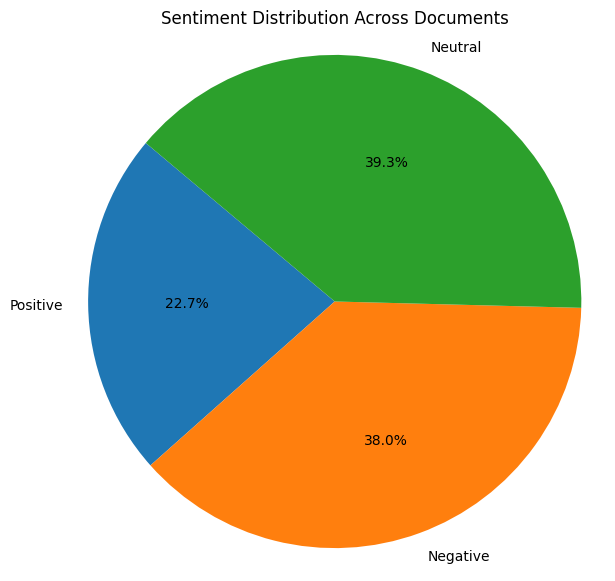

In [31]:
# Pie chart of sentiment distribution
labels = ['Positive', 'Negative', 'Neutral']
sizes = [positive_count, negative_count, neutral_count]

# Plot
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Sentiment Distribution Across Documents')
plt.axis('equal')
plt.show()

**Observation**: 

A large portion of neutral sentiment might indicate that users are expressing themselves in a factual or descriptive manner, or that their reviews contain balanced and mixed opinions. However, let us focus on the other two categories. Negative sentiment accounts for 38%, while positive sentiment is 22.7%. To determine whether negative sentiment is significantly greater than positive, we use the equation: (difference / smaller percentage) × 100. The result shows that negative sentiment is 67.40% greater than positive, indicating that large portion of users express frustration and dissatisfaction.


In [32]:
# Compute compound score and sentiment category of each platform
df['compound_score'] = df['filtered_tokens'].apply(get_sentiment_score)
platform_sentiment = df.groupby('platform')['compound_score'].mean().reset_index()
platform_sentiment['sentiment_category'] = platform_sentiment['compound_score'].apply(categorize_sentiment)
print(platform_sentiment)

  platform  compound_score sentiment_category
0   bumble       -0.038253            Neutral
1    hinge       -0.074954           Negative
2   tinder       -0.105497           Negative


**Observation**:
The compound sentiment scores across all platforms are negative. However, since a large proportion of the reviews come from Tinder, the overall negativity appears to be primarily driven by Tinder-specific feedback. Among the three platforms, Tinder reflects the most unsatisfactory user experience.

In [38]:
# Get average sentiment score of each topic
def assign_dominant_topic(ldamodel, corpus):
    return [max(ldamodel.get_document_topics(doc), key=lambda x: x[1])[0] + 1 for doc in corpus]

df['dominant_topic'] = assign_dominant_topic(optimal_model, corpus_1)

def get_sentiment_score(text):
    return analyzer.polarity_scores(text)['compound']

# Apply the function to each review
df['sentiment_score'] = df['review'].apply(get_sentiment_score)

# Group by dominant topic and compute average sentiment
topic_sentiment = df.groupby('dominant_topic')['sentiment_score'].mean().reset_index()
topic_sentiment['sentiment_category'] = topic_sentiment['sentiment_score'].apply(categorize_sentiment)
topic_sentiment.columns = ['Topic', 'Average_Sentiment', 'sentiment_category']

print(topic_sentiment.sort_values(by='Topic'))

   Topic  Average_Sentiment sentiment_category
0      1           0.015761            Neutral
1      2           0.018623            Neutral
2      3           0.054304           Positive
3      4          -0.006313            Neutral


C:\Users\xiwen\AppData\Local\Temp\ipykernel_24972\4188177539.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_sentiment, x='Topic', y='Average_Sentiment', palette='coolwarm')


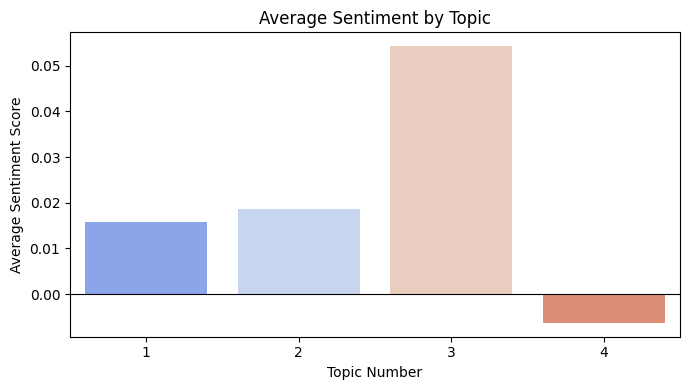

In [39]:
# Plot average sentiment score of each topic
plt.figure(figsize=(7,4))
sns.barplot(data=topic_sentiment, x='Topic', y='Average_Sentiment', palette='coolwarm')
plt.title('Average Sentiment by Topic')
plt.xlabel('Topic Number')
plt.ylabel('Average Sentiment Score')
plt.axhline(0, color='black', linewidth=0.8)
plt.tight_layout()
plt.show()

**Observation:**

Most topics are neutral, while Topic 2 indicates a positive sentiment.

In [ ]:
# Count number for reviews per topic
topic_counts = df['dominant_topic'].value_counts().reset_index()
topic_counts.columns = ['Topic', 'Review_Count']

# Display the table
print("Topics by Review Count:")
print(topic_counts)

Topics by Review Count:
   Topic  Review_Count
0      1        231037
1      2         78214
2      3         63583
3      4         16596


C:\Users\xiwen\AppData\Local\Temp\ipykernel_24972\1902332369.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=topic_counts, x='Topic', y='Review_Count', palette='viridis')


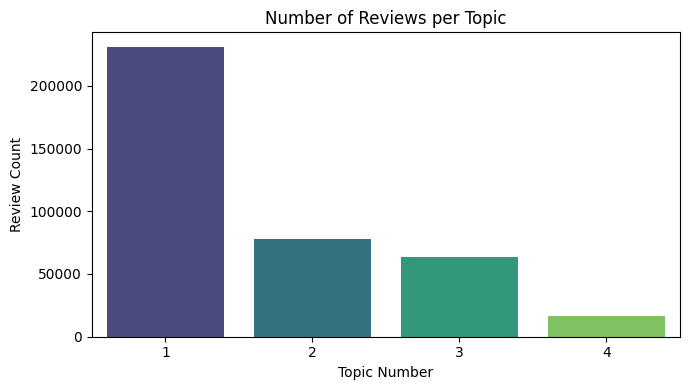

In [ ]:
# Bar chart of count number for reviews per topic 
plt.figure(figsize=(7, 4))
sns.barplot(data=topic_counts, x='Topic', y='Review_Count', palette='viridis')
plt.title('Number of Reviews per Topic')
plt.xlabel('Topic Number')
plt.ylabel('Review Count')
plt.tight_layout()
plt.show()

**Observation**:

This data reflect that topic 0 has the highest prevalent values (topic 1 in model visualization). 

## 5. Topic Summaries

| Topic | Summary | Avg Sentiment |
|-------|---------|---------------|
| 1 | Bans, Account Deletion & Subscription Issues| +0.0158 |
| 2 | Fake Profile and Dating Quality| +0.0186 |
| 3 | Paywalls and Limited Access to Features | +0.0542 |
| 4 | Technical and App Performance Problem | -0.0063 |


Each topic is interpreted based on its top keywords and sample reviews. 

## 6. Analysis

Topic 1:
0.026*"ban" + 0.021*"delete" + 0.015*"profile" + 0.013*"subscription" + 0.011*"know" + 0.011*"service" + 0.009*"experience" + 0.009*"message" + 0.009*"support" + 0.008*"love"

Topic 2:
0.047*"profile" + 0.035*"woman" + 0.029*"waste" + 0.028*"fake" + 0.027*"meet" + 0.024*"money" + 0.020*"far" + 0.015*"filter" + 0.013*"real" + 0.013*"site"

Topic 3:
0.099*"match" + 0.088*"pay" + 0.035*"message" + 0.030*"swipe" + 0.025*"free" + 0.022*"premium" + 0.014*"money" + 0.014*"notification" + 0.014*"right" + 0.011*"buy"

Topic 4:
0.048*"open" + 0.042*"load" + 0.034*"bug" + 0.023*"screen" + 0.019*"reinstall" + 0.018*"glitch" + 0.018*"interesting" + 0.017*"error" + 0.017*"fix" + 0.012*"fail"

### Topic 1 Bans, Account Deletion & Subscription Issues:

The highest-frequency words are "ban", "delete", "profile", "subscription", and "know", indicating strong user attention to platform management and various account restrictions. Users often discuss **losing access to their profiles, sometimes being banned without knowing the reason, or struggling with subscription-related issues**. Mentions of "service" and "support" suggest that users might **attempt to contact customer service**, while the presence of "love" may indicate that the **issue was resolved after contacting the platform**. The overall sentiment is neutral.

### Topic 2 Fake Profile and Dating Quality:

This topic focuses on dissatisfaction with the quality of matches. The words "profile", "woman", and "fake" indicate that users complain about the **occurrence of fake profiles** (often set up as women’s accounts). Additionally, other topic words suggest dissatisfaction with the overall dating experience, as users feel they are **wasting time or money on unsuccessful matches**. The words "far" and "filter" indicate **difficulties in arranging in-person dates** and **concerns with distance settings or filtering features**, while "real" and "site" suggest that users are **questioning the authenticity of other users or the platform itself**. Since the matching quality is based on algorithm, the recommendations systems of the platform is a crucial factor. 

### Topic 3 Paywalls and Limited Access to Features:

This topic centers on the monetization of the app, specifically essential features that require a premium subscription such as messaging, viewing matches, or using advanced swipe features. The words "premium" and "free" highlight the division between unpaid and paid features. Importantly, this topic has the only positive sentiment score, suggesting that **some users are satisfied with premium features or find them worth the cost**. Users are not only seeking the effectiveness and user experience of the features accessible through a premium subscription, but, **evaluating whether they are worth the money and provide tangible advantages after subscribing**.

### Topic 4 Technical and App Performance Problem:

This topic captures **technical difficulties such as the app failing to open, loading slowly, or experiencing bugs and glitches**. Terms like "screen", "error", and "fail" indicate performance breakdowns, while "reinstall" suggests that **users often try reinstalling as a fix**. These small technical obstacles, which prevent a smooth user experience, are an important factor contributing to user dissatisfaction and the potential decision to stop using the application.

## Thinking and Advanced Analysis

After research online pre-marketing comments on reddits and social media platforms and read papers to explore the user's needs and want, we want to combine the information we found and our research results further investigate the user experience of dating apps. The goal for this project is finding user painpoints and satisfaction areas and potential solution. There are few findings:

### 1. Efficiency and Worthiness

Through topic extraction using the LDA model, we found that efficiency drives users to focus on perceived worthiness, making it their priority. 

Rapid societal change and a fast paced lifestyle have inevitabily pushed people to seek efficiency. This tendency becomes even more pronounced in a online setting. The advantages of online dating applications include easy access to diverse opportunities unavaliable in "real-life". Without the constraints of location and time, people can manage their day with more possibilities. More importantly, dating applications can resolve the time pressureand provide instant feedback. The prominence of “time” in Topic 2 highlights how strongly users view it as a critical factor in their judgment. By facciliating the connection between strangers, these platforms cater to users crave for convenience. 

There is a underlying universal desire, to invest as little as possible while gaining the greatest return. However, such efficiency often leads to reduced patience and a heightened focus on maximizing return on investment. Through the process of setting up profile, swiping profiles, and holdind conversations, users invest resources carefully. The key word "waste" in topic 2 reflects dissatisfaction with outcome or even the system itself. Many have begun to question whether these platforms are truly designed to meet user needs and foster authentic connections, especially given the possibly poor match quality. 

The concern extends beyond effectiveness into cost evaluation. Topic 2’s association with “money” underscores the balance users seek between costs and outcomes. Additionally, topic 3 reveals that users scrutinize not only the availability of advanced features but also whether premium access is truly worth the investment. They compare paid features with free ones, evaluating whether these upgrades genuinely increase their chances of meeting their goals.

Ultimately, when efficiency dominates, users tend to have less patience, put in less effort, and form weaker emotibional connections. While such behavior may be less demaging in other industries, but it is a fatal blow for a platform designed for people to connect. It explains why many users complain that sustaining a coversation on dating apps is difficult, because people are quicker to abandon on the ongoing conversations. In conclusion, the same efficiency that drives adoption of dating apps may also undermine long-term engagement, not only on the platform itself but also in the relationships it facilitates and in broader perceptions of online dating culture.

### 2. What user needs and want through interaction.

I researched premium features across three platforms and list selected ones below:

**Bumble**

Premium: Unlimited swipes, see who liked you first, advanced filtering, change location, undo accidental left swipes, extend time to message a new match, Spotlight, 5 SuperSwipes, Incognito mode.

Premium+: Profile insights.

**Hinge**

Hinge+: Unlimited likes, advanced filtering, view all incoming likes at once.

HingeX: Enhanced recommendations, skip the line (boost), priority likes.

**Tinder**

Plus: Unlimited likes, unlimited rewinds, change location, Incognito mode.

Gold: See who likes you, new top picks every day, weekly Super Likes, 1 Boost.

Platinum: Message before matching, prioritized likes, see likes you've sent.

After listing the advanced features available through subscriptions, we have a clearer picture of the differences between “premium” and “free” access. There are four main focuses of subscriptions:

1. Gaining more attention (boosts, Spotlight, priority features)

2. Targeting more precisely (advanced filters)

3. Accessing more opportunities (more swipes, likes, or messages)

4. Getting feedback (see who liked you, profile insights)

Research has shown that dating app users often seek validation and the illusion of potential matches, what focuses 1, 3, and 4 directly address. It is important to recognize that the entire user flow is designed not only to create more opportunities for potential dates, but also to optimize the desire for intimate relationships and the attention driven need for validation in order to boost user retention and engagement. Therefore, it is reasonable for users to pay for advanced features, as premium acces fullfilled these underlying needs. Topic 3 contains the keyword “match,” and its positive sentiment indicates that users associate premium features with increased chances of success. Although they may not ultimately achieve the desired outcome (get into a relationship), the positive emotions they experience still motivate them to engage with and purchase the subscription. 

### 3. Trust issues

There is multiple trust issues across the platfroms and users. 
1. System design
- Transparency of algorithms (Users may doubt the fairness or effectiveness of matching algorithms)
- Doubts of online dating and its cultures
2. Interaction/relationship
- Profile authenticity (Topic 2: occurence of many scams, bots, and fake profiles)
- Uncertainty about whether the other side on the platform is genuinely committed to building a relationship

There are occurences of trust issues from users to users, users to platforms, and users to the online dating system. 

## Recommendations and Future work

## Recommendations
1. Create a smoother user experience by minimizing potential technical difficulties including gitching, ugs and fail to open, ensuring that users can continue using the application without interruptions. This will help reduce the second thought and guide users into a instant and seamless flow. 

2. Improve account management by implementing more accurate and precise account detection to reduce unnecessary bans or deletions. Provide users with detailed explanations of their account status and possible solutions to resolve issues. Establish a more transparent and consistent process for banning and deleting accounts, supported by an automated notification system that includes specific policy references.

3. Motivation comes from both validation and achieving desired outcomes. To enhance user engagement, focus on highlighting the validation aspect by introducing more features or functions that demonstrate the effectiveness of the dating app experience. For example, cumulated likes that received and the total number of successful matches. 

4. Feedback keeps the experience engaging. Implement quizzes or surveys to gather user preferences, enabling continuous optimization of the profile recommendation system. This approach can help introduce users to more diverse and potential matches while giving additional visibility to accounts with lower profile completeness or narrower preferences. Regularly updating these preferences, even for factors that might fall outside the existing algorithms, will allow for more precise and personalized recommendations.

5. A more advanced filtering system could include both mandatory conditions and temporary preferences. Providing users with more options and flexibility to define what they want and need can lead to more effective matches and improve overall match quality. 

6. Eliminate the fake. Set up a more robust verification process to detect and remove scams, bots and fake accounts, increase the trust from the users.

7. From Topic 3, we see that advanced features significantly enhance the user experience on dating apps. Therefore, allowing users to try these features before paying for a subscription could encourage adoption.

## Future work
From the earlier data, we observed that both the average rating over time and the number of reviews have shown a decline from 2020 to 2025. The rise of TikTok and short video content occur around the time of the peak of the popularity of dating apps. It is worth considering whether the growing influence of short videos has contributed to a decrease in the authenticity or effectiveness of dating applications. While the correlation is not proven, shorter attention spans, increased online information sharing, and heightened societal competition(with the apearence of ai), may all be contributing factors.

In the future, will users treat dating apps increasingly like marketplaces? Will users think more strategically during swiping, filtering and messages? With the decline of trust, people might cross-verify information on other platforms including instagram and linkein before commiting to deeper engagement. Richer media profiles, including short videos, could become a preferred way to verify authenticity and create a stronger sense of presence on the platform. As societal understanding of relationships diversifies, dating applications may face the challenge of serving a wide range of needs. Maybe Dating apps need to categorize profiles more granularly and implement advanced filtering systems to improve match effectiveness. 

With the emergence of AI, people may find alternative ways to express their emotions and reduce feelings of loneliness. What can dating apps, a platform designed for real human connection, do to remain relevant? There There is much to explore in addressing this challenge.